In [1]:
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  

import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image 

import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 

from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img 

import tensorflow as tf
#from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
import os
#drive.mount('/content/gdrive')
#!ls '/content/gdrive'  # take a look at the Google Drive content

In [3]:
# Mount Google Drive
drive.mount('/drive', force_remount=True)

# Location of Zip File
drive_path = '/drive/MyDrive/DP_project_xr/xray.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'xray.zip'

Mounted at /drive


## Paths and lengths

In [4]:
# Root directory for dataset
path_root = '/content/chest_xray/'
path_train= '/content/chest_xray/train/'
path_test = '/content/chest_xray/test/'
#path_val  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/'

# Root paths for X-Ray images
XRay_normal     = glob.glob(path_root+'*/NORMAL/*.jpeg', recursive=True)
XRay_pneumonial = glob.glob(path_root+'*/PNEUMONIA/*.jpeg', recursive=True)

# Root paths for X-Ray training images
train_normal    = glob.glob(path_train+'NORMAL/*.jpeg', recursive=True)
train_pneumonial= glob.glob(path_train+'PNEUMONIA/*.jpeg', recursive=True)

# X-Ray testing images 
test_normal     = os.listdir(path_test+'NORMAL/')
test_pneumonial = os.listdir(path_test+'PNEUMONIA/')

print('The "Chest X-Ray Images" dataset contains {:04d} NORMAL and {:04d} PNEUMONIA images ({:03d} in total)'\
      .format(len(XRay_normal), 
              len(XRay_pneumonial),
              len(glob.glob(path_root+'*/*/*.jpeg')),))
print('   - {:04d} NORMAL and {:04d} PNEUMONIA ==> {:04d} images in the training sample'\
      .format(len(train_normal), 
              len(train_pneumonial), 
              len(glob.glob(path_train+'*/*.jpeg'))))
print('   - {:04d} NORMAL and {:04d} PNEUMONIA ==> {:04d} images in the testing sample'\
      .format(len(test_normal), 
              len(test_pneumonial), 
              len(glob.glob(path_test+'*/*.jpeg'))))
#print('   - {:04d} NORMAL and {:04d} PNEUMONIA ==> {:04d} images in the validation sample'\
#      .format(len(glob.glob(path_val+'NORMAL/*.jpeg')), 
#              len(glob.glob(path_val+'PNEUMONIA/*.jpeg')), 
#              len(glob.glob(path_val+'*/*.jpeg'))))

The "Chest X-Ray Images" dataset contains 1583 NORMAL and 4273 PNEUMONIA images (5856 in total)
   - 1349 NORMAL and 3883 PNEUMONIA ==> 5232 images in the training sample
   - 0234 NORMAL and 0390 PNEUMONIA ==> 0624 images in the testing sample


## Compute the time

In [5]:
# Time 
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time 

## Take a quick look at of the images

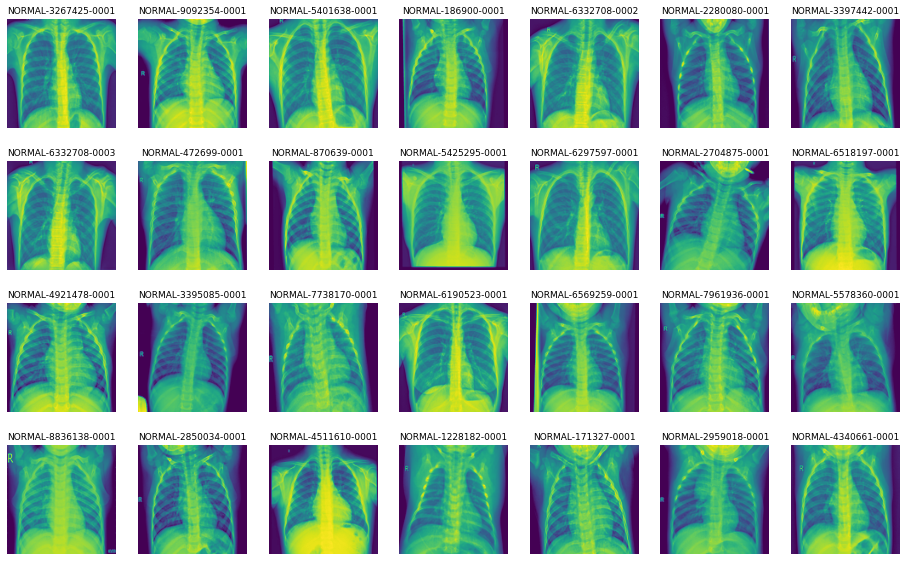

In [6]:
nrows, ncols = 4, 7
plt.figure(figsize=(16,10))
for idx, name in enumerate(test_normal[:nrows*ncols]):
    plt.subplot(nrows, ncols, idx+1)
    img = Image.open(path_test+'NORMAL/'+name) # or use plt.imread(path_test+'NORMAL/'+name)
    img = img.resize(size=(128, 128), resample=Image.ANTIALIAS, box=None)
    plt.imshow(img)
    plt.title(name[:-5], fontsize=9)
    plt.axis('off')

## Get data

In [7]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True): 
    start = time.time() 
    imgs_data = []         
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path): 
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(idx, sample_size, round(100*idx/sample_size))) 
        img = img_to_array(load_img(im_path, target_size = dim)) 
        imgs_data.append(img) 
        
    # to float 
    imgs_data = np.array(imgs_data).astype('float32') 
    # scale to [0,1] (note the . after 255 - float)
    imgs_data = imgs_data/255. #for formalizing to [-1,1] ==> (imgs_data - 127.5)/127.5 
    
    # shuffle the data 
    if rand_shuffle: 
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx) 
        imgs_data = imgs_data[idx,:,:,:] 
    
    print(f"Hey! the calculations are done in {_time(start, time.time())}")
    return imgs_data  

In [8]:
print('Starting for NORMAL X-Ray images ...')
X_normal = get_data(XRay_normal)
print()
print('Starting for PNEUMONIA X-Ray images ...')
X_pneumonial = get_data(XRay_pneumonial) 

Starting for NORMAL X-Ray images ...
Processing index 00000 of 01583 ==> 000%
Processing index 00158 of 01583 ==> 010%
Processing index 00316 of 01583 ==> 020%
Processing index 00474 of 01583 ==> 030%
Processing index 00632 of 01583 ==> 040%
Processing index 00790 of 01583 ==> 050%
Processing index 00948 of 01583 ==> 060%
Processing index 01106 of 01583 ==> 070%
Processing index 01264 of 01583 ==> 080%
Processing index 01422 of 01583 ==> 090%
Processing index 01580 of 01583 ==> 100%
Hey! the calculations are done in 33.24sec

Starting for PNEUMONIA X-Ray images ...
Processing index 00000 of 04273 ==> 000%
Processing index 00427 of 04273 ==> 010%
Processing index 00854 of 04273 ==> 020%
Processing index 01281 of 04273 ==> 030%
Processing index 01708 of 04273 ==> 040%
Processing index 02135 of 04273 ==> 050%
Processing index 02562 of 04273 ==> 060%
Processing index 02989 of 04273 ==> 070%
Processing index 03416 of 04273 ==> 080%
Processing index 03843 of 04273 ==> 090%
Processing index 0

In [9]:
def define_grid(data_images, nrows=4, ncols=5, plot_grid=True):
    # save the started time 
    start = time.time() 
    # Number of GPUs available. Use 0 for CPU mode. 
    ngpu = 1 
    # Decide which device we want to run on 
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shaphe of the data 
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid 
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')
    
    # Make the grid 
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols], 
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))
        
    # Show the output grid 
    if plot_grid:
        plt.figure(figsize=(12,12)) 
        plt.axis("off") 
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)
        
    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)
grid_X_pneumonial = define_grid(X_pneumonial, plot_grid=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.19sec
The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.08sec


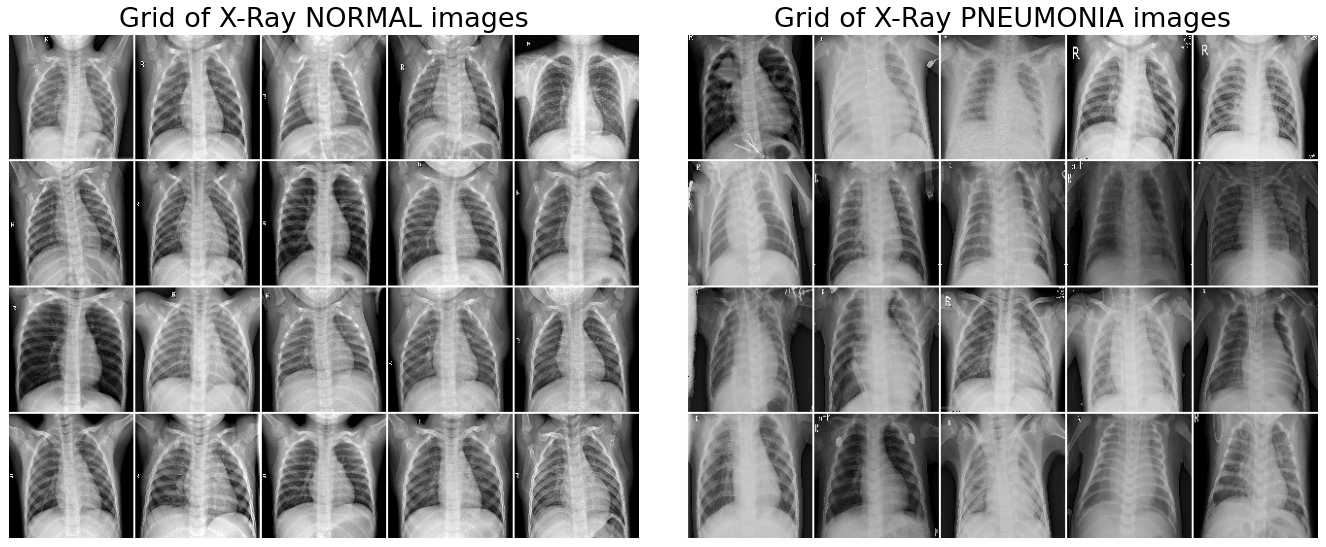

In [10]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray NORMAL images', fontsize = 27)

ax2.imshow(grid_X_pneumonial); ax2.axis('off')
ax2.set_title(label = 'Grid of X-Ray PNEUMONIA images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

## Set the parameters

In [11]:
# Number of images to use (will be changed)
#n_images = 12_000 

# Number of training epochs
n_epoch = 200 

# Batch size during training 
batch_size = 128 

# Size of z latent vector (i.e. size of generator input) 
latent_dim = 100 

# Spatial size of training images. All images will be resized to this size 
cols, rows = 128, 128 

# Number of channels in the training images. For RGB color images this is 3
channels = 3 
dim = cols, rows # height, width 
in_shape = (cols, rows, channels) # height, width, color 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 

# plot ncols images in row and nrows images in colomn
nrows, ncols = 3, 4

## Discriminator

In [12]:
def define_discriminator(in_shape=(128,128,3)): 
    model = models.Sequential() 
    # normal 
    model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape)) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 64x64 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 32x32 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 16x16 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 8x8 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # classifier 
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1, activation='sigmoid')) 
    # compile model 
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return model

## Generator

In [13]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model 

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

## Define GAN Model

In [14]:
def define_gan(g_model, d_model): 
    # make weights in the discriminator not trainable
    d_model.trainable = False 
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images 
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1] 
    #generated = (generated+1)/2 
    #generated = (generated[:ncols*nrows]*127.5)+127.5 
    #generated = generated*255 
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off') 
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot 
    show_generated(x_fake, epoch)  
    
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

## Train the Models

In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=200, n_batch=128):
    
    start = time.time() 
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3 = [], [], [] 
    fake_liste = [] 
    
    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss) 
        
        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance 
        if (i+1)%(n_epochs//10) == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim) 
        
    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))
    
    # Show loss curves 
    loss = (loss1, loss2, loss3) 
    plot_loss(loss) 

In [16]:
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 

# create the gan 
gan = define_gan(generator, discriminator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training Start...
Epoch: 001/200, Loss: [D_real = 0.369, D_fake = 0.853, G = 0.765], time: 1min 11.07sec
Epoch: 002/200, Loss: [D_real = 0.001, D_fake = 0.264, G = 3.021], time: 44.04sec
Epoch: 003/200, Loss: [D_real = 0.076, D_fake = 0.684, G = 0.778], time: 43.19sec
Epoch: 004/200, Loss: [D_real = 0.003, D_fake = 0.356, G = 1.534], time: 43.08sec
Epoch: 005/200, Loss: [D_real = 0.076, D_fake = 0.588, G = 1.046], time: 43.2sec
Epoch: 006/200, Loss: [D_real = 0.219, D_fake = 0.656, G = 1.078], time: 43.08sec
Epoch: 007/200, Loss: [D_real = 0.670, D_fake = 1.067, G = 0.768], time: 43.67sec
Epoch: 008/200, Loss: [D_real = 0.713, D_fake = 0.674, G = 1.193], time: 43.15sec
Epoch: 009/200, Loss: [D_real = 0.801, D_fake = 0.507, G = 1.344], time: 43.24sec
Epoch: 010/200, Loss: [D_real = 0.732, D_fake = 0.530, G = 1.206], time: 43.13sec
Epoch: 011/200, Loss: [D_real = 0.580, D_fake = 0.686, G = 1.010], time: 43.24sec
Epoch: 012/200, Loss: [D_real = 0.599, D_fake = 0.647, G = 0.950], time: 43.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 20 [real: 91%, fake: 75%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

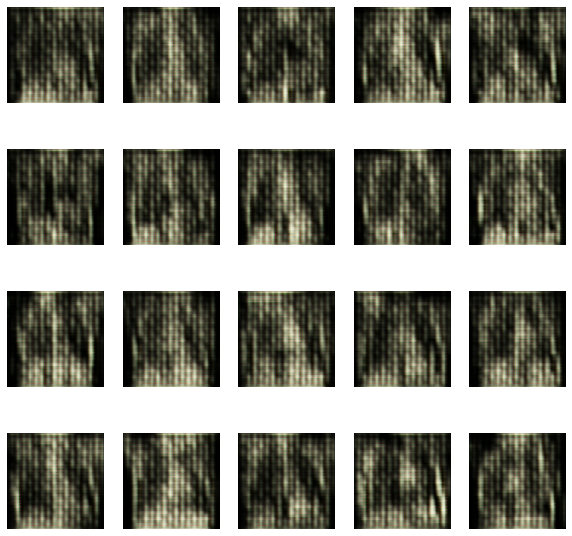

Epoch: 021/200, Loss: [D_real = 0.424, D_fake = 0.486, G = 2.022], time: 43.71sec
Epoch: 022/200, Loss: [D_real = 0.488, D_fake = 0.575, G = 1.098], time: 43.35sec
Epoch: 023/200, Loss: [D_real = 0.515, D_fake = 0.705, G = 1.363], time: 43.23sec
Epoch: 024/200, Loss: [D_real = 0.472, D_fake = 0.553, G = 1.498], time: 43.9sec
Epoch: 025/200, Loss: [D_real = 0.633, D_fake = 0.554, G = 1.541], time: 43.16sec
Epoch: 026/200, Loss: [D_real = 0.541, D_fake = 0.644, G = 2.051], time: 43.26sec
Epoch: 027/200, Loss: [D_real = 0.415, D_fake = 0.460, G = 1.982], time: 44.31sec
Epoch: 028/200, Loss: [D_real = 1.554, D_fake = 1.610, G = 2.418], time: 43.9sec
Epoch: 029/200, Loss: [D_real = 0.394, D_fake = 0.336, G = 2.200], time: 43.16sec
Epoch: 030/200, Loss: [D_real = 0.197, D_fake = 0.243, G = 3.591], time: 43.9sec
Epoch: 031/200, Loss: [D_real = 0.419, D_fake = 0.397, G = 2.224], time: 43.22sec
Epoch: 032/200, Loss: [D_real = 0.300, D_fake = 0.356, G = 2.757], time: 43.21sec
Epoch: 033/200, Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 40 [real: 93%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

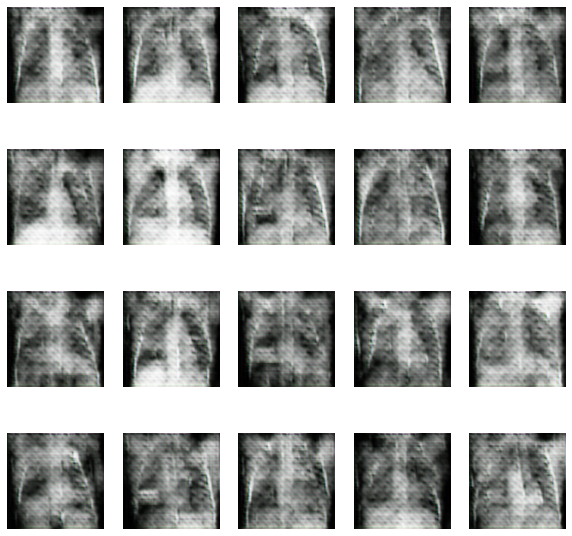

Epoch: 041/200, Loss: [D_real = 0.549, D_fake = 0.331, G = 3.288], time: 43.34sec
Epoch: 042/200, Loss: [D_real = 0.433, D_fake = 0.409, G = 2.865], time: 43.29sec
Epoch: 043/200, Loss: [D_real = 0.358, D_fake = 0.463, G = 2.941], time: 43.29sec
Epoch: 044/200, Loss: [D_real = 0.343, D_fake = 0.189, G = 2.410], time: 43.27sec
Epoch: 045/200, Loss: [D_real = 0.378, D_fake = 0.362, G = 3.630], time: 43.25sec
Epoch: 046/200, Loss: [D_real = 0.603, D_fake = 0.405, G = 2.491], time: 43.23sec
Epoch: 047/200, Loss: [D_real = 0.490, D_fake = 0.619, G = 2.854], time: 43.2sec
Epoch: 048/200, Loss: [D_real = 0.412, D_fake = 0.247, G = 2.537], time: 43.27sec
Epoch: 049/200, Loss: [D_real = 0.589, D_fake = 0.634, G = 2.830], time: 43.3sec
Epoch: 050/200, Loss: [D_real = 0.272, D_fake = 0.283, G = 2.889], time: 43.09sec
Epoch: 051/200, Loss: [D_real = 0.564, D_fake = 0.582, G = 1.171], time: 43.36sec
Epoch: 052/200, Loss: [D_real = 0.322, D_fake = 0.313, G = 2.594], time: 44.93sec
Epoch: 053/200, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 60 [real: 77%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

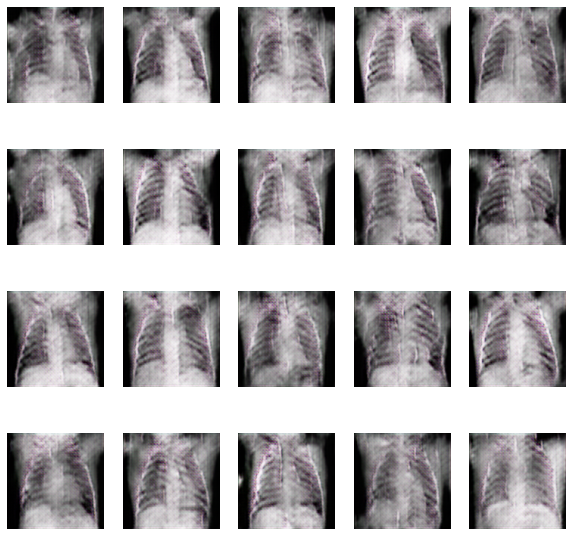

Epoch: 061/200, Loss: [D_real = 0.299, D_fake = 0.430, G = 2.122], time: 43.11sec
Epoch: 062/200, Loss: [D_real = 0.265, D_fake = 0.444, G = 2.891], time: 43.36sec
Epoch: 063/200, Loss: [D_real = 0.361, D_fake = 0.510, G = 3.140], time: 43.16sec
Epoch: 064/200, Loss: [D_real = 0.571, D_fake = 0.496, G = 3.032], time: 43.2sec
Epoch: 065/200, Loss: [D_real = 0.539, D_fake = 0.589, G = 3.206], time: 43.31sec
Epoch: 066/200, Loss: [D_real = 0.226, D_fake = 0.397, G = 3.391], time: 43.31sec
Epoch: 067/200, Loss: [D_real = 0.582, D_fake = 0.557, G = 3.072], time: 43.2sec
Epoch: 068/200, Loss: [D_real = 0.380, D_fake = 0.432, G = 3.060], time: 44.26sec
Epoch: 069/200, Loss: [D_real = 0.259, D_fake = 0.253, G = 3.187], time: 43.07sec
Epoch: 070/200, Loss: [D_real = 0.184, D_fake = 0.162, G = 3.565], time: 43.7sec
Epoch: 071/200, Loss: [D_real = 0.265, D_fake = 0.850, G = 5.015], time: 43.76sec
Epoch: 072/200, Loss: [D_real = 0.558, D_fake = 0.416, G = 2.359], time: 43.27sec
Epoch: 073/200, Los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 80 [real: 90%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

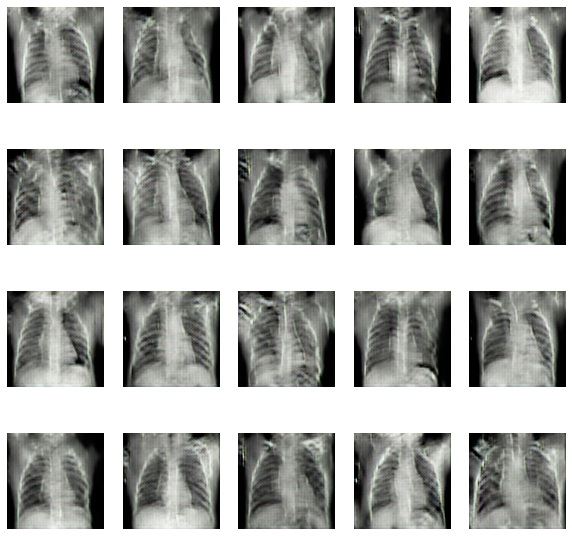

Epoch: 081/200, Loss: [D_real = 0.332, D_fake = 0.405, G = 3.673], time: 43.5sec
Epoch: 082/200, Loss: [D_real = 0.232, D_fake = 0.280, G = 3.301], time: 43.27sec
Epoch: 083/200, Loss: [D_real = 0.286, D_fake = 0.198, G = 3.220], time: 43.27sec
Epoch: 084/200, Loss: [D_real = 0.234, D_fake = 0.304, G = 3.495], time: 43.74sec
Epoch: 085/200, Loss: [D_real = 0.665, D_fake = 0.440, G = 3.524], time: 43.21sec
Epoch: 086/200, Loss: [D_real = 0.268, D_fake = 0.503, G = 4.822], time: 43.84sec
Epoch: 087/200, Loss: [D_real = 0.457, D_fake = 0.326, G = 3.646], time: 43.16sec
Epoch: 088/200, Loss: [D_real = 0.457, D_fake = 0.401, G = 3.405], time: 43.25sec
Epoch: 089/200, Loss: [D_real = 0.259, D_fake = 0.270, G = 4.005], time: 43.81sec
Epoch: 090/200, Loss: [D_real = 0.339, D_fake = 0.221, G = 2.877], time: 43.13sec
Epoch: 091/200, Loss: [D_real = 0.362, D_fake = 0.304, G = 3.026], time: 43.64sec
Epoch: 092/200, Loss: [D_real = 0.284, D_fake = 0.293, G = 3.333], time: 43.34sec
Epoch: 093/200, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 100 [real: 80%, fake: 94%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

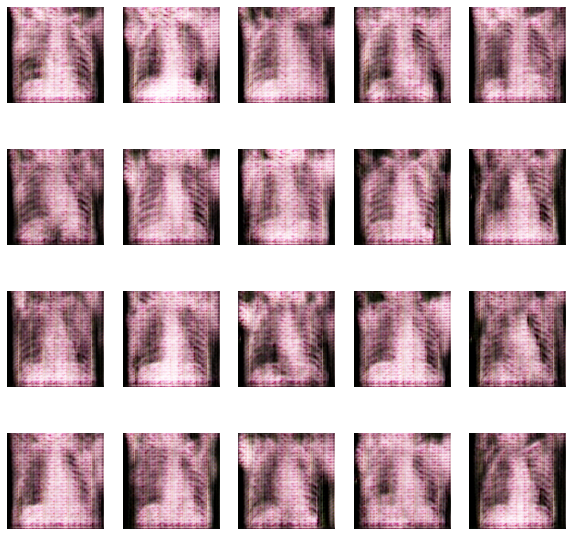

Epoch: 101/200, Loss: [D_real = 0.464, D_fake = 0.444, G = 1.881], time: 43.29sec
Epoch: 102/200, Loss: [D_real = 0.841, D_fake = 0.775, G = 1.606], time: 43.14sec
Epoch: 103/200, Loss: [D_real = 0.659, D_fake = 0.721, G = 1.806], time: 43.87sec
Epoch: 104/200, Loss: [D_real = 0.631, D_fake = 0.559, G = 1.482], time: 43.82sec
Epoch: 105/200, Loss: [D_real = 0.777, D_fake = 0.639, G = 1.734], time: 43.77sec
Epoch: 106/200, Loss: [D_real = 0.461, D_fake = 0.588, G = 1.690], time: 43.37sec
Epoch: 107/200, Loss: [D_real = 0.585, D_fake = 0.610, G = 1.724], time: 43.29sec
Epoch: 108/200, Loss: [D_real = 0.410, D_fake = 0.583, G = 2.300], time: 43.83sec
Epoch: 109/200, Loss: [D_real = 0.572, D_fake = 0.580, G = 1.752], time: 43.84sec
Epoch: 110/200, Loss: [D_real = 0.633, D_fake = 0.537, G = 1.692], time: 43.17sec
Epoch: 111/200, Loss: [D_real = 0.454, D_fake = 0.386, G = 1.918], time: 43.3sec
Epoch: 112/200, Loss: [D_real = 0.504, D_fake = 0.538, G = 1.940], time: 43.08sec
Epoch: 113/200, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 120 [real: 78%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

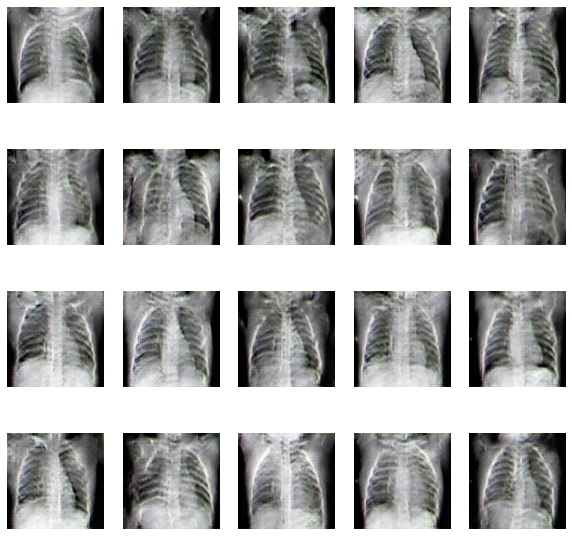

Epoch: 121/200, Loss: [D_real = 0.624, D_fake = 0.475, G = 1.666], time: 43.88sec
Epoch: 122/200, Loss: [D_real = 0.590, D_fake = 0.574, G = 1.530], time: 43.15sec
Epoch: 123/200, Loss: [D_real = 0.503, D_fake = 0.625, G = 1.813], time: 43.3sec
Epoch: 124/200, Loss: [D_real = 0.564, D_fake = 0.439, G = 1.773], time: 43.23sec
Epoch: 125/200, Loss: [D_real = 0.411, D_fake = 0.399, G = 1.880], time: 44.34sec
Epoch: 126/200, Loss: [D_real = 0.448, D_fake = 0.546, G = 1.739], time: 43.17sec
Epoch: 127/200, Loss: [D_real = 0.506, D_fake = 0.534, G = 1.581], time: 43.29sec
Epoch: 128/200, Loss: [D_real = 0.474, D_fake = 0.540, G = 1.960], time: 43.22sec
Epoch: 129/200, Loss: [D_real = 0.486, D_fake = 0.488, G = 1.945], time: 43.17sec
Epoch: 130/200, Loss: [D_real = 0.436, D_fake = 0.382, G = 1.789], time: 43.16sec
Epoch: 131/200, Loss: [D_real = 0.544, D_fake = 0.519, G = 1.575], time: 43.15sec
Epoch: 132/200, Loss: [D_real = 0.450, D_fake = 0.512, G = 1.817], time: 43.23sec
Epoch: 133/200, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 140 [real: 75%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

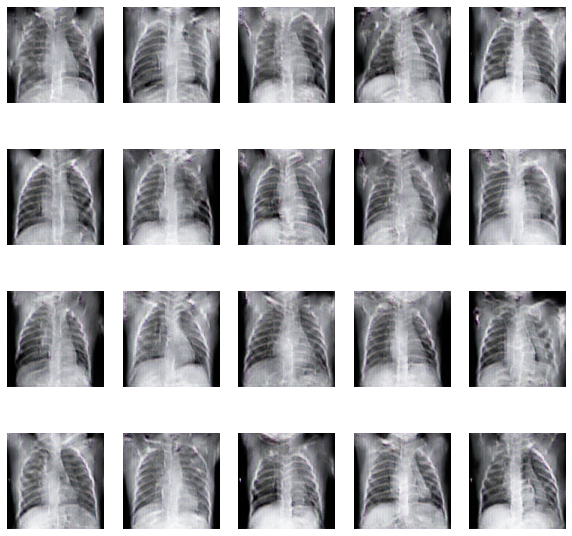

Epoch: 141/200, Loss: [D_real = 0.541, D_fake = 0.558, G = 1.666], time: 43.16sec
Epoch: 142/200, Loss: [D_real = 0.499, D_fake = 0.491, G = 1.687], time: 44.32sec
Epoch: 143/200, Loss: [D_real = 0.573, D_fake = 0.470, G = 1.480], time: 43.38sec
Epoch: 144/200, Loss: [D_real = 0.523, D_fake = 0.510, G = 1.544], time: 43.11sec
Epoch: 145/200, Loss: [D_real = 0.584, D_fake = 0.754, G = 1.866], time: 43.57sec
Epoch: 146/200, Loss: [D_real = 0.503, D_fake = 0.530, G = 1.781], time: 44.49sec
Epoch: 147/200, Loss: [D_real = 0.699, D_fake = 0.452, G = 1.611], time: 43.33sec
Epoch: 148/200, Loss: [D_real = 0.647, D_fake = 0.432, G = 1.521], time: 43.23sec
Epoch: 149/200, Loss: [D_real = 0.488, D_fake = 0.420, G = 1.753], time: 43.96sec
Epoch: 150/200, Loss: [D_real = 0.516, D_fake = 0.492, G = 2.088], time: 43.13sec
Epoch: 151/200, Loss: [D_real = 0.504, D_fake = 0.436, G = 1.718], time: 43.85sec
Epoch: 152/200, Loss: [D_real = 0.531, D_fake = 0.495, G = 1.564], time: 43.84sec
Epoch: 153/200, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 160 [real: 63%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

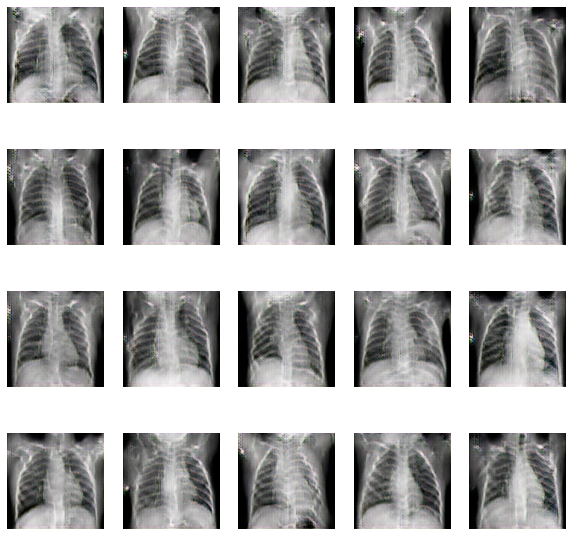

Epoch: 161/200, Loss: [D_real = 0.526, D_fake = 0.455, G = 1.766], time: 43.74sec
Epoch: 162/200, Loss: [D_real = 0.608, D_fake = 0.524, G = 1.713], time: 43.09sec
Epoch: 163/200, Loss: [D_real = 0.519, D_fake = 0.543, G = 1.543], time: 44.6sec
Epoch: 164/200, Loss: [D_real = 0.352, D_fake = 0.431, G = 1.991], time: 43.23sec
Epoch: 165/200, Loss: [D_real = 0.350, D_fake = 0.407, G = 1.776], time: 43.23sec
Epoch: 166/200, Loss: [D_real = 0.548, D_fake = 0.502, G = 1.754], time: 43.18sec
Epoch: 167/200, Loss: [D_real = 0.397, D_fake = 0.444, G = 1.879], time: 43.16sec
Epoch: 168/200, Loss: [D_real = 0.494, D_fake = 0.474, G = 1.788], time: 43.21sec
Epoch: 169/200, Loss: [D_real = 0.607, D_fake = 0.493, G = 1.764], time: 43.11sec
Epoch: 170/200, Loss: [D_real = 0.628, D_fake = 0.493, G = 1.825], time: 43.29sec
Epoch: 171/200, Loss: [D_real = 0.386, D_fake = 0.366, G = 1.917], time: 43.82sec
Epoch: 172/200, Loss: [D_real = 0.400, D_fake = 0.609, G = 2.160], time: 43.87sec
Epoch: 173/200, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 180 [real: 81%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

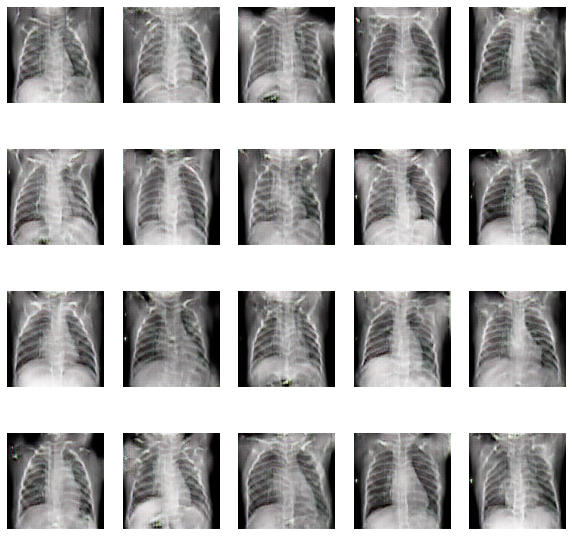

Epoch: 181/200, Loss: [D_real = 0.433, D_fake = 0.436, G = 1.966], time: 43.33sec
Epoch: 182/200, Loss: [D_real = 0.577, D_fake = 0.422, G = 1.668], time: 43.82sec
Epoch: 183/200, Loss: [D_real = 0.586, D_fake = 0.473, G = 1.767], time: 43.25sec
Epoch: 184/200, Loss: [D_real = 0.421, D_fake = 0.380, G = 1.988], time: 43.15sec
Epoch: 185/200, Loss: [D_real = 0.552, D_fake = 0.436, G = 1.860], time: 43.14sec
Epoch: 186/200, Loss: [D_real = 0.456, D_fake = 0.294, G = 2.140], time: 43.25sec
Epoch: 187/200, Loss: [D_real = 0.567, D_fake = 0.464, G = 2.023], time: 43.83sec
Epoch: 188/200, Loss: [D_real = 0.621, D_fake = 0.436, G = 1.619], time: 43.34sec
Epoch: 189/200, Loss: [D_real = 0.329, D_fake = 0.408, G = 2.255], time: 43.85sec
Epoch: 190/200, Loss: [D_real = 0.226, D_fake = 0.325, G = 2.513], time: 43.31sec
Epoch: 191/200, Loss: [D_real = 0.477, D_fake = 0.441, G = 1.906], time: 43.16sec
Epoch: 192/200, Loss: [D_real = 0.609, D_fake = 0.703, G = 1.901], time: 43.18sec
Epoch: 193/200, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 200 [real: 85%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

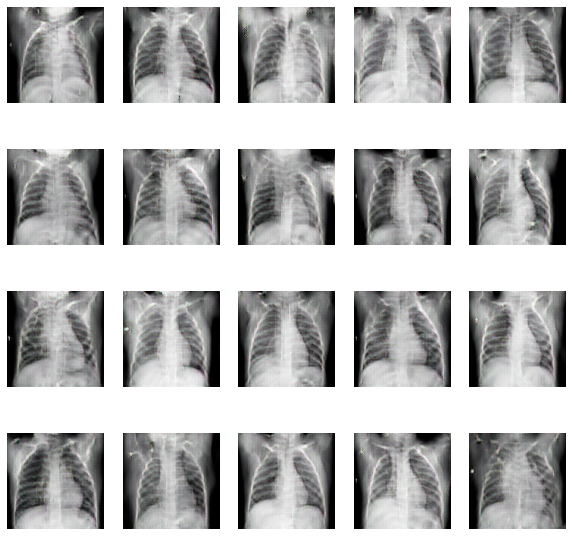

Total time for training 200 epochs is 2h 25min 44.92sec sec


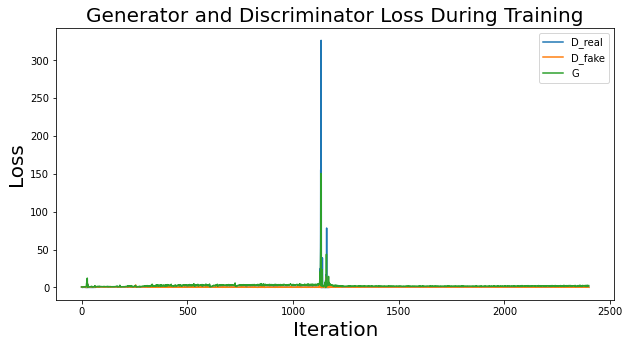

In [17]:
# train model 
train(generator, discriminator, gan, X_normal, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

In [18]:
# use the generator to generate n fake
def XRayFakeGenerator(g_model=generator, latent_dim =100, n_samples=100, show_gen=False):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input)  
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

XRay_fake = XRayFakeGenerator(generator, n_samples=20)

In [19]:
# SAVE TO ZIP FILE 
import zipfile
output_path = zipfile.PyZipFile('/content/XRayN2Fake.zip', mode='w')

XRay_generated = XRayFakeGenerator(n_samples=10000)
for idx in range(XRay_generated.shape[0]):
    img_XRayFake  = XRay_generated[idx,:,:]
    name_XRayFake = 'XRay_generated {:04d}.png'.format(idx)
    imageio.imwrite(name_XRayFake, img_XRayFake)
    
    output_path.write(name_XRayFake)
    os.remove(name_XRayFake) 
output_path.close()


Streaming output truncated to the last 5000 lines.
